In [3]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

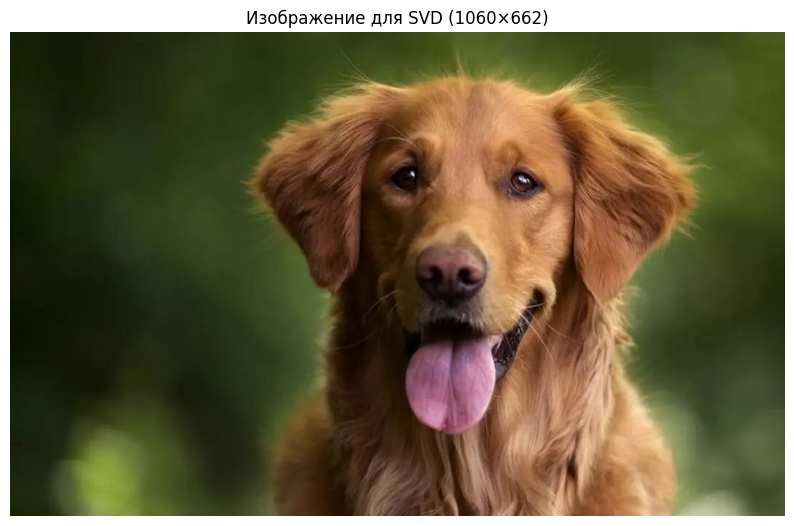

Размер массива: (662, 1060, 3)
Диапазон значений: от 0.0 до 255.0


In [4]:
# Чтение изображения
name = "dog.jpg"

img = Image.open(name)

# Отображение
w, h = img.size
plt.figure(figsize=(10, 7))
plt.imshow(img)
plt.title(f"Изображение для SVD ({img.size[0]}×{img.size[1]})")
plt.axis('off')
plt.show()

# Преобразование в numpy array
img_array = np.array(img, dtype=np.float32)
print(f"Размер массива: {img_array.shape}")
print(f"Диапазон значений: от {img_array.min():.1f} до {img_array.max():.1f}")

In [5]:
# SVD разложение
print("SVD разложение матрицы изображения...")

# Разделяем на каналы
R = img_array[:, :, 0]
G = img_array[:, :, 1]
B = img_array[:, :, 2]

# Применяем SVD к каждому каналу
U_R, S_R, Vt_R = np.linalg.svd(R, full_matrices=False)
U_G, S_G, Vt_G = np.linalg.svd(G, full_matrices=False)
U_B, S_B, Vt_B = np.linalg.svd(B, full_matrices=False)

#  Все 3 матрицы одинакового размера)
print(f"Размер матриц U: {U_R.shape}")
print(f"Размер диагональных матриц S: {S_R.shape}")
print(f"Размер матриц Vt: {Vt_R.shape}")
print(f"Количество сингулярных значений: {len(S_R)}")

SVD разложение матрицы изображения...
Размер матриц U: (662, 662)
Размер диагональных матриц S: (662,)
Размер матриц Vt: (662, 1060)
Количество сингулярных значений: 662


In [6]:
# Функция для восстановления изображения
def reconstruct_image(U, S, Vt, k):

    # Используем только первые k сингулярных значений
    U_k = U[:, :k]
    S_k = np.diag(S[:k])
    Vt_k = Vt[:k, :]

    # Восстанавливаем матрицу изображения
    reconstructed = U_k @ S_k @ Vt_k

    # Ограничиваем значения в допустимом диапазоне для изображения
    reconstructed = np.clip(reconstructed, 0, 255)

    return reconstructed.astype(np.uint8)

In [7]:
# Восстановление изображений
print("Восстановление изображений...")

# Определяем размеры
m, n = R.shape
max_k = min(m, n)
k_values = [1, 2, 10, 30, 100, max_k]

results = {}
for k in k_values:
    # Восстанавливаем каждый канал отдельно
    R_rec = reconstruct_image(U_R, S_R, Vt_R, k)
    G_rec = reconstruct_image(U_G, S_G, Vt_G, k)
    B_rec = reconstruct_image(U_B, S_B, Vt_B, k)

    # Объединяем каналы обратно
    reconstructed = np.stack([R_rec, G_rec, B_rec], axis=2)

    if k == max_k:
        compression_ratio_percent = 100.0
        compression_factor = 1.0
        mse = 0
        compressed_elements = 3 * (m * k + k + k * n)
    else:
        # Количество элементов для хранения 3 каналов
        compressed_elements = 3 * (m * k + k + k * n)
        compression_ratio_percent = (compressed_elements / (3 * m * n)) * 100
        compression_factor = (3 * m * n) / compressed_elements

        # Вычисляем MSE
        original_normalized = img_array / 255.0
        reconstructed_normalized = reconstructed.astype(np.float32) / 255.0
        mse = np.mean((original_normalized - reconstructed_normalized) ** 2)

    results[k] = {
        'image': reconstructed,
        'compression_ratio_percent': compression_ratio_percent,
        'compression_factor': compression_factor,
        'mse': mse,
        'compressed_elements': compressed_elements,
        'size_bytes': compressed_elements * 4}

print("Восстановление завершено")

Восстановление изображений...
Восстановление завершено


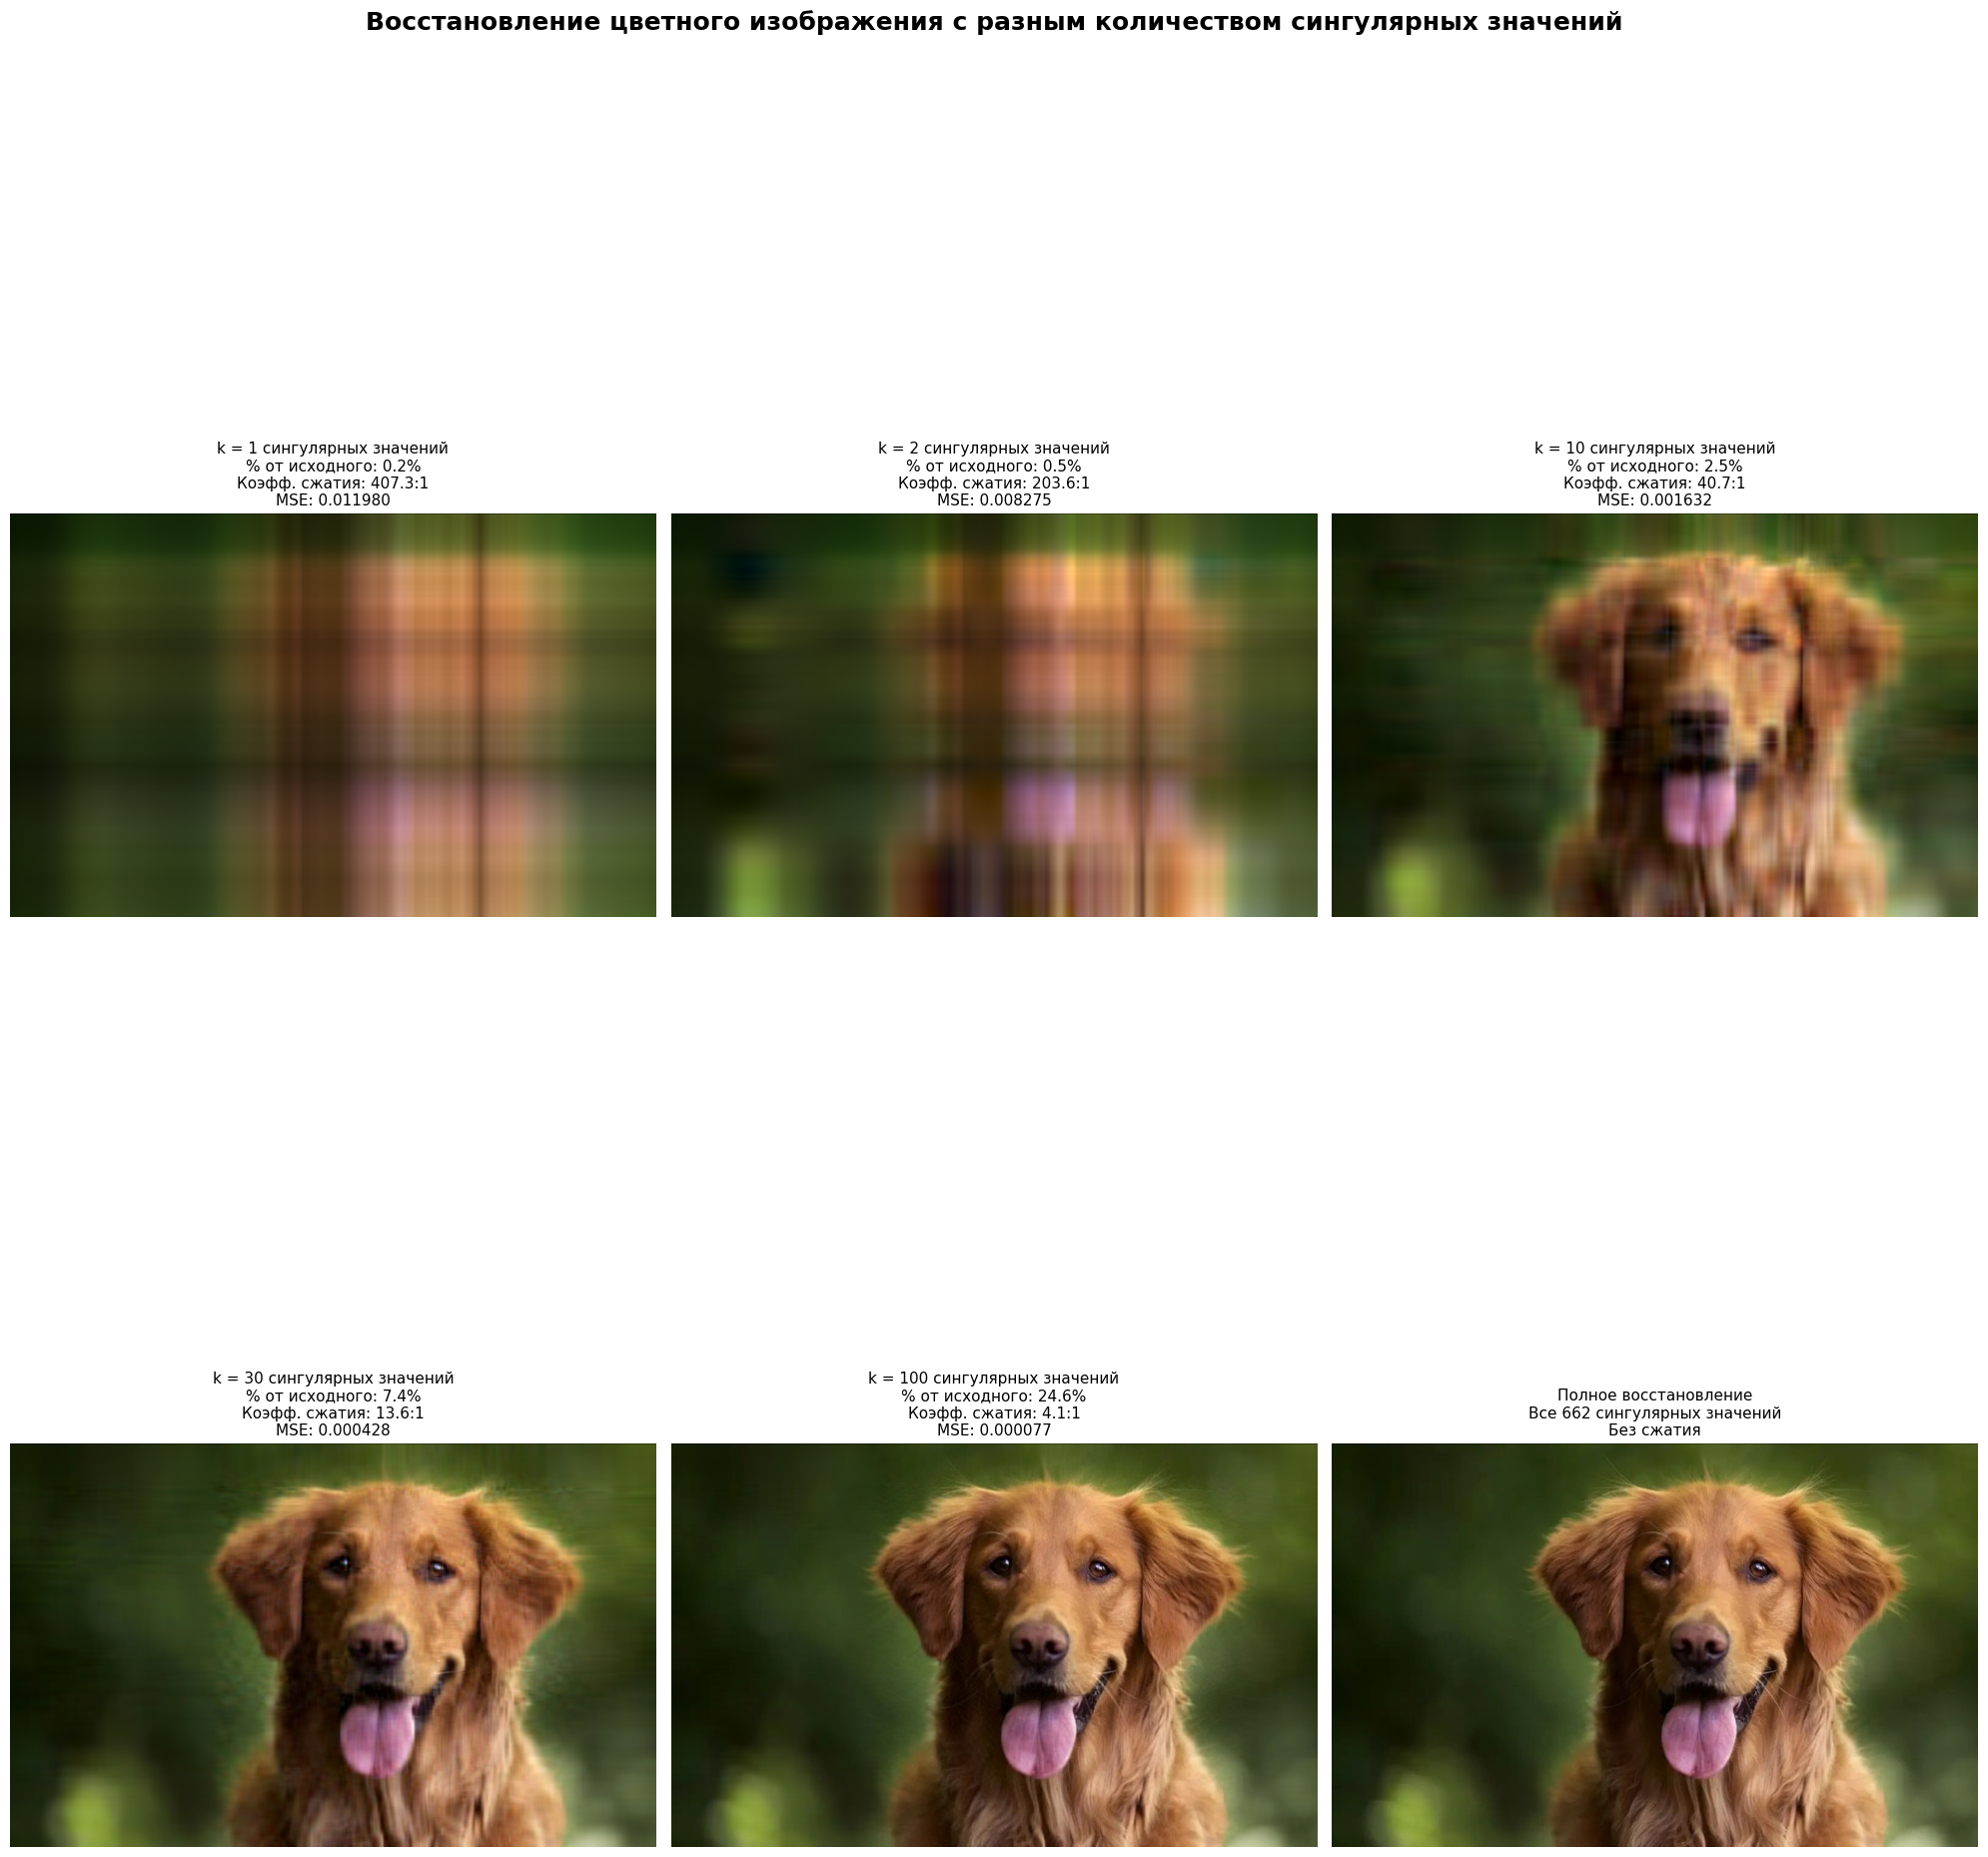

Сравнительная таблица сжатых изображений:

----------------------------------------------------------------------
k     Количество байт    % от исходного     Коэф. сжатия       MSE       
----------------------------------------------------------------------
1            20676            0.7%            135.8:1        0.0120
2            41352            1.5%             67.9:1        0.0083
10          206760            7.4%             13.6:1        0.0016
30          620280           22.1%              4.5:1        0.0004
100        2067600           73.7%              1.4:1        0.0001
------------------------ исходное изображение ------------------------ 
662        2806880          100.0%                1:1          0.00


In [8]:
# Визуализация восстановленных изображений
plt.figure(figsize=(20, 24))
for i, k in enumerate(k_values):
    data = results[k]

    plt.subplot(2, 3, i+1)
    plt.imshow(data['image'])

    if k == max_k:
        title = f'Полное восстановление\nВсе {k} сингулярных значений\nБез сжатия'
    else:
        title = (f'k = {k} сингулярных значений\n'
                 f'% от исходного: {data["compression_ratio_percent"]:.1f}%\n'
                 f'Коэфф. сжатия: {data["compression_factor"]:.1f}:1\n'
                 f'MSE: {data["mse"]:.6f}')

    plt.title(title, fontsize=11)
    plt.axis('off')

plt.suptitle('Восстановление цветного изображения с разным количеством сингулярных значений',
             fontweight='bold', fontsize=18)
plt.tight_layout()
plt.show()

# Сравнительная таблица
print("Сравнительная таблица сжатых изображений:")

print("\n" + "-" * 70)
print(f"{'k':<5} {'Количество байт':<18} {'% от исходного':<18} {'Коэф. сжатия':<18} {'MSE':<10}")
print("-" * 70)

for k in k_values:
    data = results[k]

    if k == max_k:
        print("------------------------ исходное изображение ------------------------ ")
        print(f"{k:<5} {m * n * 4:12}          {'100.0%':<15}       {'1:1':5}  {0:10.2f}")
    else:
        percent = (data['size_bytes']) / (m * n * 4) * 100
        ratio = (m * n * 4) / data['size_bytes']

        print(f"{k:<5} {data['size_bytes']:12}   {percent:12.1f}% {ratio:16.1f}:1  {data['mse']:12.4f}")